# Librerías
___
### Básicas
- **`numpy`**: Biblioteca para realizar cálculos matemáticos, trabajar con arrays multidimensionales y operaciones algebraicas.
- **`pandas`**: Herramienta para manipulación y análisis de datos, ideal para trabajar con datos tabulares (DataFrames).
- **`matplotlib.pyplot`**: Biblioteca para crear gráficos y visualizaciones simples.
- **`seaborn`**: Extensión de Matplotlib para crear gráficos estadísticos más visuales y atractivos.

---

### Selección de Modelos y Validación
- **`train_test_split`**: Divide los datos en conjuntos de entrenamiento y prueba.
- **`cross_val_score`**: Realiza validación cruzada para evaluar la eficacia de los modelos.

---

### Modelos de Regresión
#### Regresión Lineal y Variantes
- **`LinearRegression`**: Modelo de regresión lineal básico.
- **`SGDRegressor`**: Optimización mediante descenso de gradiente estocástico.
- **`Lasso`**: Regresión lineal con regularización L1 para seleccionar características importantes.
- **`Ridge`**: Regresión lineal con regularización L2 para penalizar grandes coeficientes.
- **`ElasticNet`**: Combinación de Lasso y Ridge.

#### Otros Modelos de Regresión
- **`SVR`**: Regresión basada en máquinas de soporte vectorial.
- **`KNeighborsRegressor`**: Modelo basado en vecinos más cercanos.
- **`DecisionTreeRegressor`**: Árbol de decisión para tareas de regresión.

---

### Modelos de Ensamble
- **`RandomForestRegressor`**: Combina múltiples árboles de decisión para mejorar las predicciones.
- **`BaggingRegressor`**: Entrena varios modelos en subconjuntos aleatorios de datos.
- **`ExtraTreesRegressor`**: Variante de Random Forest con árboles aleatorios adicionales.
- **`AdaBoostRegressor`**: Combina modelos débiles utilizando boosting adaptativo.

---

### Modelos Avanzados
- **`XGBRegressor`**: Implementación eficiente de boosting por gradiente.
- **`CatBoostRegressor`**: Modelo que maneja eficientemente variables categóricas.
- **`LGBMRegressor`**: Modelo rápido para boosting en conjuntos de datos grandes.

---

### Métricas de Evaluación
- **`mean_squared_error`**: Calcula el error cuadrático medio entre los valores reales y predichos.
- **`r2_score`**: Coeficiente de determinación, mide qué tan bien los valores predichos se ajustan a los reales.
- **`mean_absolute_error`**: Calcula el error absoluto medio entre los valores reales y predichos.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# Cargar los datos de generación y meteorológicos
plant_1_generation = pd.read_csv('Plant_1_Generation_Data.csv')
plant_1_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

# Copiar los datos de generación para mantener df_GD1 limpio
df_SP1 = plant_1_generation.copy()

# Aplicar el mapeo a los nombres de los paneles solares
unique_source_keys_list = df_SP1['SOURCE_KEY'].unique()
source_key_mapping = {key: f"Solar_Panel_{i+1}" for i, key in enumerate(unique_source_keys_list)}
df_SP1['SOURCE_KEY'] = df_SP1['SOURCE_KEY'].map(source_key_mapping)

# Convertir la columna 'DATE_TIME' a formato de fecha y hora
df_SP1['DATE_TIME'] = pd.to_datetime(df_SP1['DATE_TIME'], format='%d-%m-%Y %H:%M')
plant_1_weather['DATE_TIME'] = pd.to_datetime(plant_1_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Unir los datos meteorológicos al dataframe de generación en función de la fecha y hora
df_SP1_with_weather = pd.merge(df_SP1, plant_1_weather, on='DATE_TIME', how='left')

# Eliminar las columnas PLANT_ID_y y SOURCE_KEY_y y renombrar las columnas PLANT_ID_x y SOURCE_KEY_x
df_SP1_with_weather = df_SP1_with_weather.drop(columns=['PLANT_ID_y', 'SOURCE_KEY_y','PLANT_ID_x'])

# Renombrar las columnas para eliminar el sufijo '_x'
df_SP1_with_weather = df_SP1_with_weather.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY'})

df_SP1_with_weather.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,Solar_Panel_1,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15,Solar_Panel_2,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0
2,2020-05-15,Solar_Panel_3,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0
3,2020-05-15,Solar_Panel_4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0
4,2020-05-15,Solar_Panel_5,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0


### Mostrar cuántos valores nulos hay por columna
- **`isnull()`**: Identifica valores nulos en el DataFrame.
- **`sum()`**: Suma el número de valores nulos por columna.


### Rellenar valores nulos con la media
- **`select_dtypes()`**: Selecciona columnas numéricas para aplicar imputación.
- **`fillna()`**: Rellena valores nulos en las columnas numéricas con la media de cada una.
- **`mean()`**: Calcula la media de los valores no nulos en cada columna.

In [4]:
# Mostrar cuántos valores nulos hay por columna
print("Valores nulos en cada columna: \n", df_SP1_with_weather.isnull().sum())

# Rellenar los valores nulos en solo las columnas numéricas con la media
numerical_cols_1 = df_SP1_with_weather.select_dtypes(include=['float64', 'int64']).columns #EstO para quitar los floats
df_SP1_with_weather[numerical_cols_1] = df_SP1_with_weather[numerical_cols_1].fillna(df_SP1_with_weather[numerical_cols_1].mean())

Valores nulos en cada columna: 
 DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    4
MODULE_TEMPERATURE     4
IRRADIATION            4
dtype: int64


In [5]:
print(df_SP1_with_weather.isnull().sum())

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


___
### Definir características y objetivo
- **`variables`**: Lista de columnas seleccionadas como variables independientes para entrenar el modelo.
- **`X`**: Matriz de variables independientes extraída del DataFrame.
- **`Y`**: Vector de la variable objetivo, que corresponde a `DC_POWER`.

In [7]:
variables = ['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE', 'IRRADIATION','DAILY_YIELD']
# Definir X (variables predictoras) y Y (variable objetivo)
X = df_SP1_with_weather[variables]
Y = df_SP1_with_weather['DC_POWER']

___

### Visualización de valores atípicos con boxplots
- **Boxplots (gráficos de caja)**:
  - **`plt.figure()`**: Configura el tamaño general de la figura (15x10).
  - **`plt.subplot()`**: Organiza los gráficos en 2 filas y 3 columnas.
  - **`sns.boxplot()`**: Crea gráficos de caja para cada variable, mostrando su distribución y los valores atípicos.
  - **`plt.title()`**: Asigna un título a cada gráfico indicando la variable analizada.
  - **`plt.ylabel()`**: Etiqueta el eje Y con el nombre de la variable.
  - **`plt.tight_layout()`**: Ajusta los espacios entre gráficos para evitar superposiciones.
  - **`plt.show()`**: Muestra todos los gráficos generados.


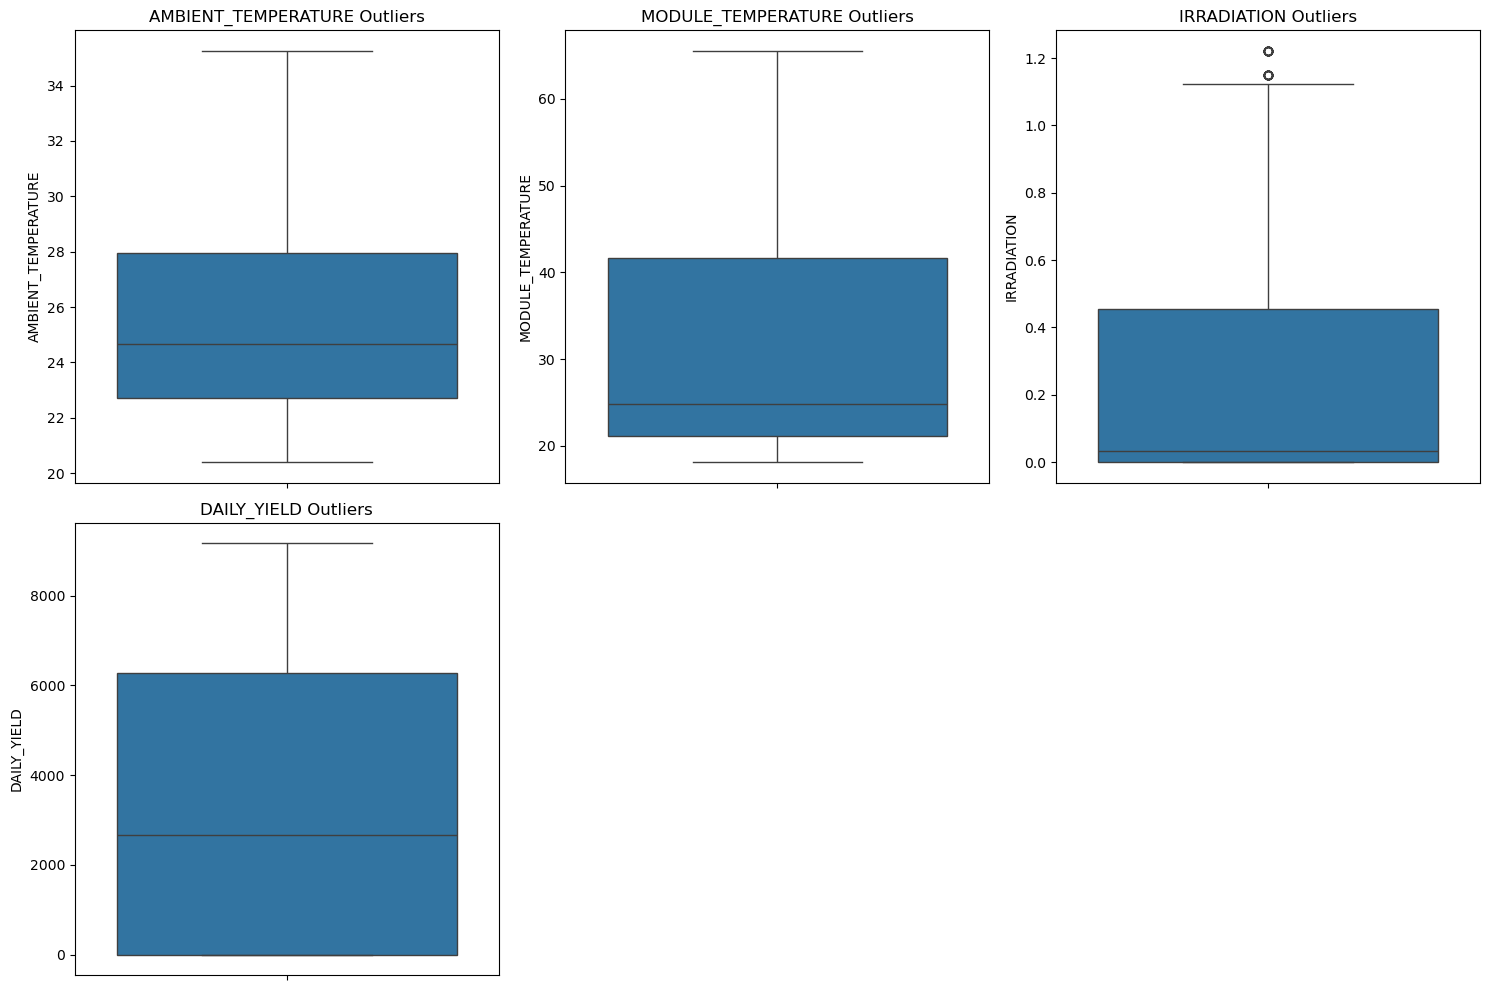

In [8]:
# Create boxplots to visualize outliers
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # Arrange in 2 rows and 3 columns
    sns.boxplot(data=df_SP1_with_weather, y=var)
    plt.title(f'{var} Outliers')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

### Filtrado de valores atípicos (Outliers)
- **Rango intercuartil (IQR)**:
  - **`quantile(0.25)`**: Calcula el primer cuartil (Q1), correspondiente al 25% de los datos más bajos.
  - **`quantile(0.75)`**: Calcula el tercer cuartil (Q3), correspondiente al 75% de los datos más altos.
  - **IQR**: Rango intercuartil, calculado como `IQR = Q3 - Q1`.
  - **Límites**:
    - **Límite inferior**: `Q1 - 1.5 * IQR`.
    - **Límite superior**: `Q3 + 1.5 * IQR`.
  - **Filtrado de valores atípicos**: Solo se mantienen los datos que están dentro de los límites definidos.

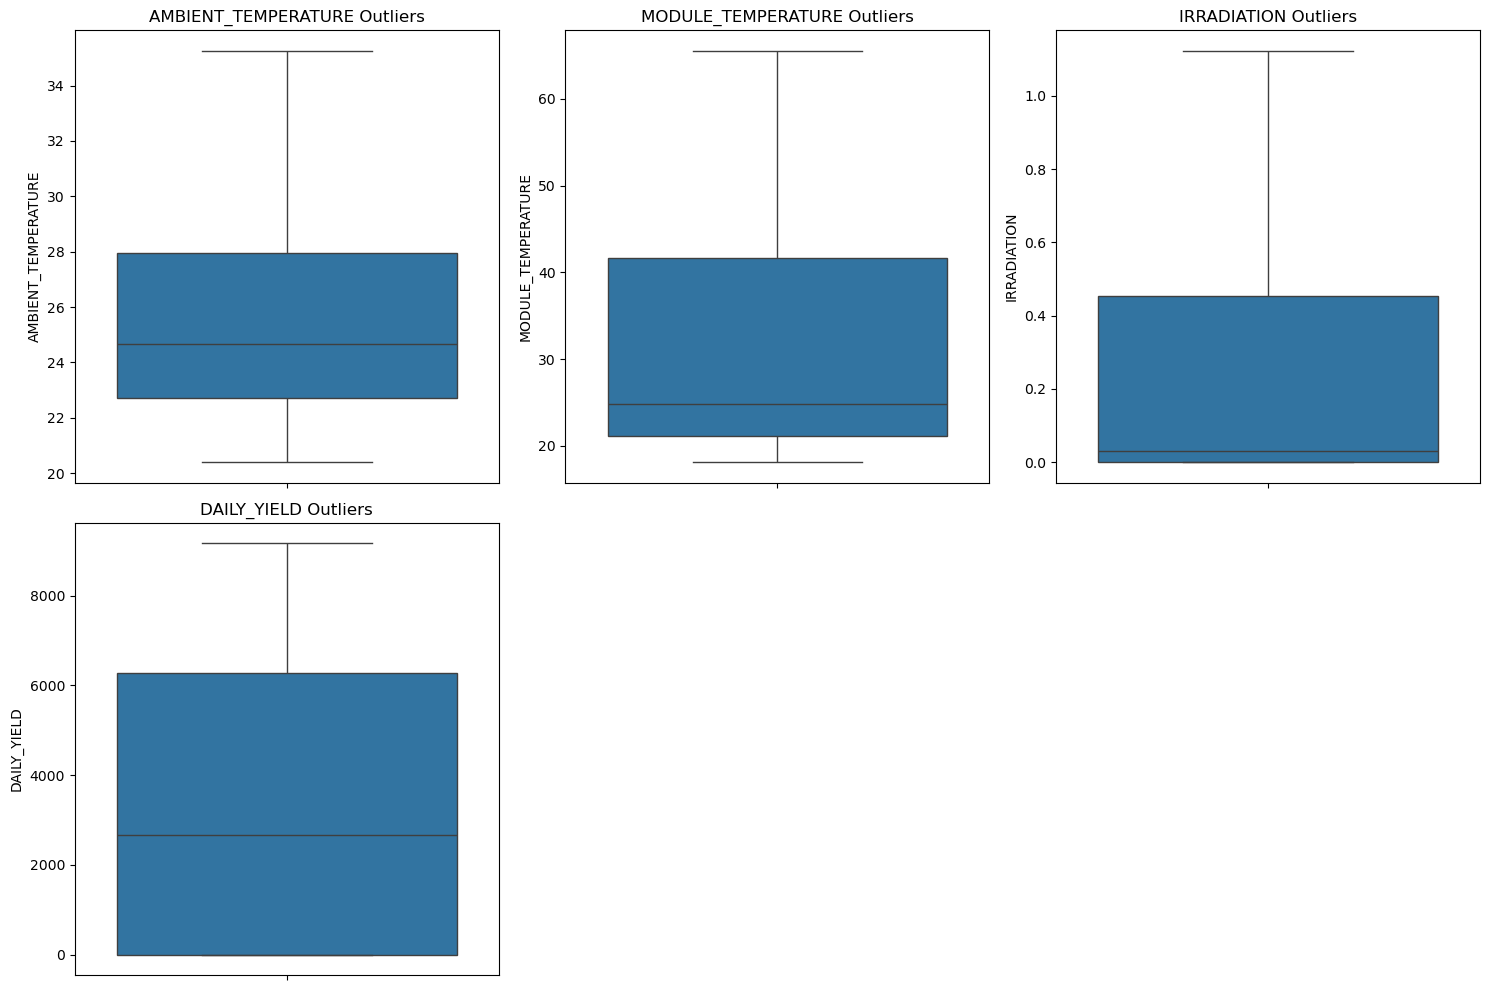

In [9]:
for var in variables:
    Q1 = df_SP1_with_weather[var].quantile(0.25)
    Q3 = df_SP1_with_weather[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_SP1_with_weather = df_SP1_with_weather[(df_SP1_with_weather[var] >= lower_bound) & (df_SP1_with_weather[var] <= upper_bound)]
    
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # Arrange in 2 rows and 3 columns
    sns.boxplot(data=df_SP1_with_weather, y=var)
    plt.title(f'{var} Outliers')
    plt.ylabel(var)
plt.tight_layout()
plt.show()


____

# Entrenamiento

### División del conjunto de datos en entrenamiento y prueba
- **`train_test_split()`**:
  - Divide los datos en conjuntos de entrenamiento y prueba.
  - **`X_train`** y **`Y_train`**: Datos de entrada y salida para entrenamiento.
  - **`X_test`** y **`Y_test`**: Datos de entrada y salida para prueba.
  - **Parámetros**:
    - **`test_size=0.2`**: El 20% de los datos se reserva para pruebas.
    - **`random_state=42`**: Garantiza que la división sea reproducible.
    - **`shuffle=True`**: Mezcla los datos antes de dividirlos.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

### Definición de Modelos
Se instancian múltiples modelos de regresión para evaluar diferentes enfoques de aprendizaje automático:

1. **`AdaBoostRegressor()`**:
   - Modelo de ensamble basado en boosting adaptativo, combina predicciones de modelos débiles para mejorar la precisión.

2. **`BaggingRegressor()`**:
   - Ensamble que utiliza muestreo aleatorio con reemplazo para crear modelos base independientes.

3. **`CatBoostRegressor(verbose=0)`**:
   - Modelo especializado en datos categóricos, eficiente y robusto.

4. **`DecisionTreeRegressor()`**:
   - Árbol de decisión para tareas de regresión, particiona los datos según reglas.

5. **`ElasticNet()`**:
   - Regresión lineal con penalizaciones combinadas L1 (Lasso) y L2 (Ridge).

6. **`ExtraTreesRegressor()`**:
   - Ensamble de árboles con mayor aleatoriedad en las divisiones.

7. **`KNeighborsRegressor()`**:
   - Algoritmo basado en vecinos cercanos, predice en función del promedio de los valores de los vecinos más cercanos.

8. **`Lasso()`**:
   - Regresión con regularización L1, reduce algunos coeficientes a cero para mayor simplicidad.

9. **`LGBMRegressor(verbose=0)`**:
   - Modelo de boosting eficiente diseñado para grandes datasets.

10. **`LinearRegression()`**:
    - Regresión lineal clásica.

11. **`RandomForestRegressor()`**:
    - Ensamble de múltiples árboles de decisión, reduce el sobreajuste.

12. **`Ridge()`**:
    - Regresión con regularización L2, penaliza grandes coeficientes.

13. **`SVR()`**:
    - Soporte vectorial para regresión, encuentra un hiperplano óptimo.

14. **`XGBRegressor(verbosity=0)`**:
    - Modelo de boosting basado en gradientes, reconocido por su rendimiento.

15. **`SGDRegressor()`**:
    - Descenso de gradiente estocástico, útil para datasets grandes y problemas de regresión.

In [11]:
model_1 = AdaBoostRegressor()
model_2 = BaggingRegressor()
model_3 = CatBoostRegressor(verbose=0)
model_4 = DecisionTreeRegressor()
model_5 = ElasticNet()
model_6 = ExtraTreesRegressor()
model_7 = KNeighborsRegressor()
model_8 = Lasso()
model_9 = LGBMRegressor(verbose=0)
model_10 = LinearRegression()
model_11 = RandomForestRegressor()
model_12 = Ridge()
model_13 = SVR()
model_14 = XGBRegressor(verbosity=0)
model_15 = SGDRegressor()

In [12]:
model_1.fit(X_train, y_train)

AdaBoostRegressor()

In [13]:
model_2.fit(X_train, y_train)   

BaggingRegressor()

In [14]:
model_3.fit(X_train, y_train)

In [15]:
model_4.fit(X_train, y_train)   

DecisionTreeRegressor()

In [16]:
model_5.fit(X_train, y_train)  

ElasticNet()

In [17]:
model_6.fit(X_train, y_train)

ExtraTreesRegressor()

In [18]:
model_7.fit(X_train, y_train)

KNeighborsRegressor()

In [19]:
model_8.fit(X_train, y_train)

Lasso()

In [20]:
model_9.fit(X_train, y_train)

LGBMRegressor(verbose=0)

In [21]:
model_10.fit(X_train, y_train)

LinearRegression()

In [22]:
model_11.fit(X_train, y_train)

RandomForestRegressor()

In [23]:
model_12.fit(X_train, y_train)

Ridge()

In [24]:
model_13.fit(X_train, y_train)

SVR()

In [25]:
model_14.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
model_15.fit(X_train, y_train)

SGDRegressor()

# Evaluación y Selección de Modelos de Machine Learning

## Umbrales Configurables
- **`LOW_THRESHOLD = 0.65`**: Modelos con puntuaciones de entrenamiento y prueba por debajo de este valor se consideran "malos."
- **`MIDDLE_LOW = 0.65` y `MIDDLE_HIGH = 0.80`**: Definen un rango medio para clasificar modelos.
- **`HIGH_THRESHOLD = 0.80`**: Modelos con puntuaciones altas alcanzan este umbral.
- **`OVERFIT_RATIO = 1.20`**: Ratio para detectar sobreajuste si la puntuación de entrenamiento es significativamente mejor que la de prueba.

## Cálculo de Métricas y Evaluación de Modelos
1. **Bucle sobre los Modelos**:
   - Calcula las métricas principales:
     - **`Mean Squared Error (MSE)`** y **`Mean Absolute Error (MAE)`**.
     - **Puntuaciones de Entrenamiento y Prueba**: `model.score`.
     - **R² Score**: Para evaluar el ajuste del modelo.
     - **Ratio Difference**: Diferencia entre las puntuaciones de entrenamiento y prueba para detectar sobreajuste.
   - Asigna un estado a cada modelo basado en las métricas:
     - **`bad`**: Mal rendimiento tanto en entrenamiento como en prueba.
     - **`overfit`**: Signo de sobreajuste (entrenamiento mucho mejor que prueba).
     - **`middle`**: Rendimiento moderado.
     - **`good`**: Buen rendimiento en ambas puntuaciones.
     - Otros estados: **`high train, low test`**, **`unknown`**.

2. **Normalización de Puntuaciones**:
   - Convierte las puntuaciones de entrenamiento y prueba a porcentajes para mejor interpretación.

## Construcción del DataFrame
- Contiene las siguientes columnas:
  - **`Modelo`**: Nombre del modelo.
  - **`Train score`**: Puntuación de entrenamiento (%).
  - **`Test score`**: Puntuación de prueba (%).
  - **`R² score`**: Ajuste del modelo.
  - **`Ratio difference`**: Diferencia entre puntuaciones.
  - **`Evaluate model`**: Clasificación del modelo.
  - **`Squared error`** y **`Mean Absolute Error (MAE)`**.

- **Filtrado**:
  - Se eliminan modelos con puntuaciones de entrenamiento fuera del rango de 0% a 105%.
- **Ordenamiento**:
  - Modelos ordenados por **`R² score`** de forma descendente.

## Visualización de Resultados
- **`styled_model_score`**:
  - Aplica un gradiente de color en la columna **`R² score`** usando la paleta `viridis` para facilitar la interpretación visual.

## Identificación del Mejor Modelo
- Se selecciona el modelo con el **R² score** más alto:
  - **Nombre del Modelo**: Impreso en consola.
  - **Modelo Mejor Clasificado**: Utilizado para evaluaciones adicionales.

## Validación Cruzada (Cross-Validation)
1. **Parámetros**:
   - Número de pliegues (`cv_folds`): 5.
   - Métrica de evaluación: **`R² score`**.
2. **Resultados**:
   - **Promedio del R² Score**: Media de las puntuaciones en los pliegues.
   - **Desviación Estándar**: Variabilidad entre pliegues.
   - Resultados presentados en un DataFrame con la puntuación de cada pliegue.

## Salidas Clave
1. **Tabla Resumen de Modelos**:
   - Incluye métricas detalladas y clasificaciones de rendimiento.
2. **Mejor Modelo**:
   - Nombre y detalles del modelo seleccionado.
3. **Validación Cruzada**:
   - Puntuaciones promedio y desviación estándar por pliegue.
   - Detalles de cada pliegue en un DataFrame.


In [27]:
# List of models:
models = [model_1, model_2, model_3, model_4, model_5,
          model_6, model_7, model_8, model_9, model_10,
          model_11, model_12, model_13, model_14, model_15]  
models_names = ['AdaBoostRegressor', 
                'BaggingRegressor', 
                'CatBoostRegressor', 
                'DecisionTreeRegressor', 
                'ElasticNet', 
                'ExtraTreesRegressor', 
                'KNeighborsRegressor', 
                'LGBMRegressor', 
                'Lasso', 
                'LinearRegression', 
                'RandomForestRegressor', 
                'Ridge', 
                'SVR', 
                'XGBRegressor',
                'SGDRegressor'] 

# Configurable thresholds
LOW_THRESHOLD = 0.65
MIDDLE_LOW = 0.65
MIDDLE_HIGH = 0.80
HIGH_THRESHOLD = 0.80
OVERFIT_RATIO = 1.20

# Initialize lists for metrics
squared_errors = []
mae_values = []
train_scores = []
test_scores = []
r2_scores = []
ratios = []
rates = []

# Loop through models and calculate metrics
for model, model_name in zip(models, models_names):
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    r2 = r2_score(y_test, y_pred)
    
    # Ratio Difference
    ratio_diff = train_score - test_score
    
    # Evaluate model state
    if train_score <= LOW_THRESHOLD and test_score <= LOW_THRESHOLD:
        state = 'bad'
    elif train_score > test_score * OVERFIT_RATIO:
        state = 'overfit'
    elif train_score == 1.00 and test_score >= 0.85:
        state = 'good but high train score'  # New condition
    elif MIDDLE_LOW < train_score < MIDDLE_HIGH and MIDDLE_LOW < test_score < MIDDLE_HIGH:
        state = 'middle'
    elif HIGH_THRESHOLD <= test_score < 1.00 and HIGH_THRESHOLD <= train_score < 1.00:
        state = 'good'
    elif train_score >= HIGH_THRESHOLD and test_score < HIGH_THRESHOLD:
        state = 'high train, low test'
    else:
        state = 'unknown'
    
    # Append results
    squared_errors.append(f'{mse:.2f}')
    mae_values.append(f'{mae:.2f}')
    train_scores.append(train_score)
    test_scores.append(test_score)
    r2_scores.append(r2)
    ratios.append(f'{ratio_diff * 100:.2f}%')
    rates.append(state)

# Normalize train and test scores as percentages
train_scores_pct = [f'{round(score * 100, 2)}%' for score in train_scores]
test_scores_pct = [f'{round(score * 100, 2)}%' for score in test_scores]

# Create the final DataFrame
model_score = pd.DataFrame({
    'Modelo': models_names,
    'Train score': train_scores_pct,
    'Test score': test_scores_pct,
    'R² score': [f'{round(r2, 2)}' for r2 in r2_scores],
    'Ratio difference': ratios,
    'Evaluate model': rates,
    'Squared error': squared_errors,
    'Mean Absolute Error (MAE)': mae_values
})

# Convert Train score to float for filtering
model_score['Train score (float)'] = model_score['Train score'].str.rstrip('%').astype(float)

# Filter models where Train score is between 0 and 105%
model_score = model_score[(model_score['Train score (float)'] >= 0) & (model_score['Train score (float)'] <= 105)]

# Drop the temporary column
model_score = model_score.drop(columns=['Train score (float)'])

# Sort models by R² score in descending order
model_score = model_score.sort_values(by='R² score', ascending=False)

# Display styled DataFrame
styled_model_score = model_score.style.background_gradient(subset=['R² score'], cmap='viridis')
display(styled_model_score)

# Identify the best model based on R² score
best_model_index = r2_scores.index(max(r2_scores))  # Index of the best model
best_model_name = models_names[best_model_index]
best_model = models[best_model_index]

print(f"\nBest model: {best_model_name}")

# Perform Cross-Validation for the Best Model
cv_folds = 5  # Number of folds for cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv_folds, scoring='r2')

# Display Cross-Validation Results
print(f"\nCross-Validation Results for {best_model_name}:")
print(f"Mean R² Score: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of R² Scores: {np.std(cv_scores):.2f}")

# Append cross-validation scores to a DataFrame for optional analysis
cv_results = pd.DataFrame({
    'Fold': range(1, cv_folds + 1),
    'R² Score': cv_scores
})

# Display the CV results
print("\nCross-Validation Scores per Fold:")
print(cv_results)

,Modelo,Train score,Test score,R² score,Ratio difference,Evaluate model,Squared error,Mean Absolute Error (MAE)
1,BaggingRegressor,99.81%,99.04%,0.99,0.78%,good,155703.49,149.39
2,CatBoostRegressor,99.21%,99.07%,0.99,0.15%,good,150698.05,165.51
3,DecisionTreeRegressor,100.0%,98.68%,0.99,1.32%,good,213239.14,168.78
5,ExtraTreesRegressor,100.0%,99.0%,0.99,1.00%,good,162380.88,150.06
8,Lasso,98.95%,98.88%,0.99,0.07%,good,181218.88,171.38
10,RandomForestRegressor,99.86%,99.09%,0.99,0.77%,good,146652.43,145.36
13,XGBRegressor,99.38%,99.18%,0.99,0.20%,good,132966.65,153.76
7,LGBMRegressor,97.89%,97.91%,0.98,-0.02%,good,338257.43,266.00
9,LinearRegression,97.9%,97.91%,0.98,-0.02%,good,337988.71,265.55
11,Ridge,97.9%,97.91%,0.98,-0.02%,good,338000.56,265.62



Best model: XGBRegressor

Cross-Validation Results for XGBRegressor:
Mean R² Score: 0.99
Standard Deviation of R² Scores: 0.00

Cross-Validation Scores per Fold:
   Fold  R² Score
0     1  0.991159
1     2  0.990096
2     3  0.990468
3     4  0.989875
4     5  0.989675


___
## Gráficas de los resultados obtenidos

1. **Gráfica de Puntajes de Entrenamiento y Prueba**:
   - Muestra una comparación visual entre el rendimiento en entrenamiento y prueba para cada modelo. 
   - Útil para identificar discrepancias significativas que pueden indicar sobreajuste o subajuste.

2. **Gráfica de R² Score**:
   - Representa el coeficiente de determinación (R²) de cada modelo.
   - Permite evaluar qué tan bien cada modelo explica la variabilidad de los datos objetivos.

3. **Gráfica de Error Cuadrático Medio (MSE)**:
   - Muestra el error cuadrático medio, que mide la magnitud de los errores al cuadrado.
   - Ayuda a identificar modelos con menor error global en las predicciones.

4. **Gráfica de Error Absoluto Medio (MAE)**:
   - Representa el error promedio absoluto de las predicciones.
   - Es útil para interpretar la magnitud promedio de los errores en términos prácticos.

5. **Gráfica de Diferencia entre Puntajes de Entrenamiento y Prueba**:
   - Visualiza la diferencia porcentual entre las puntuaciones de entrenamiento y prueba.
   - Indicador clave para evaluar la generalización del modelo y detectar problemas de sobreajuste.

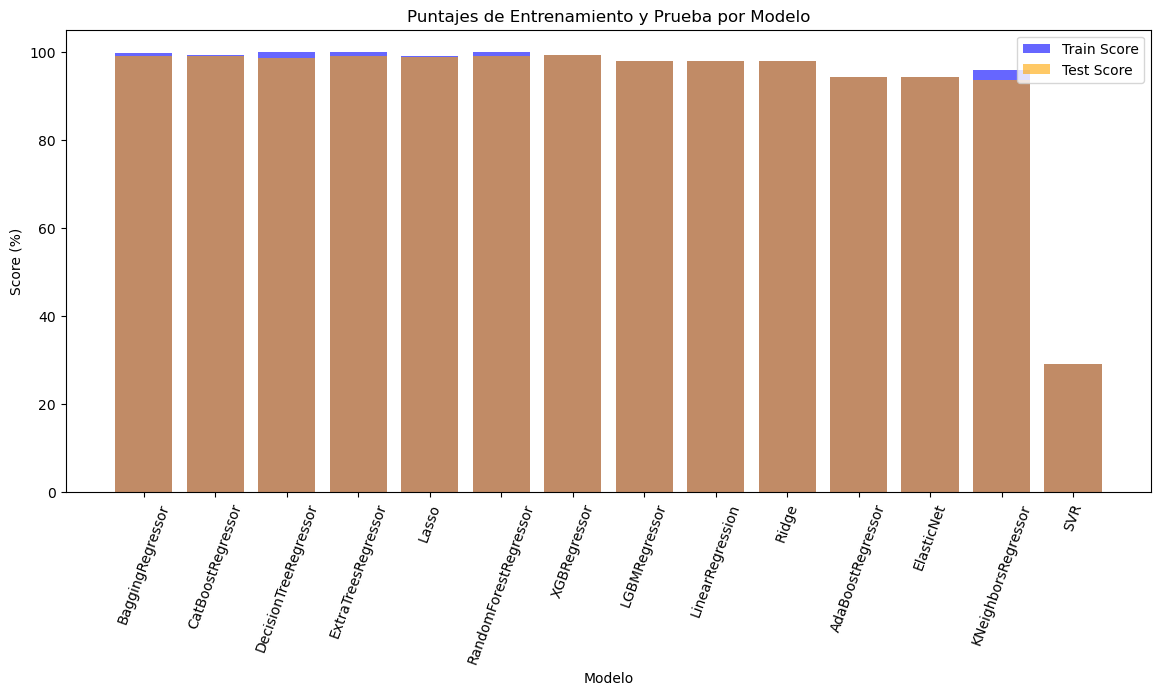

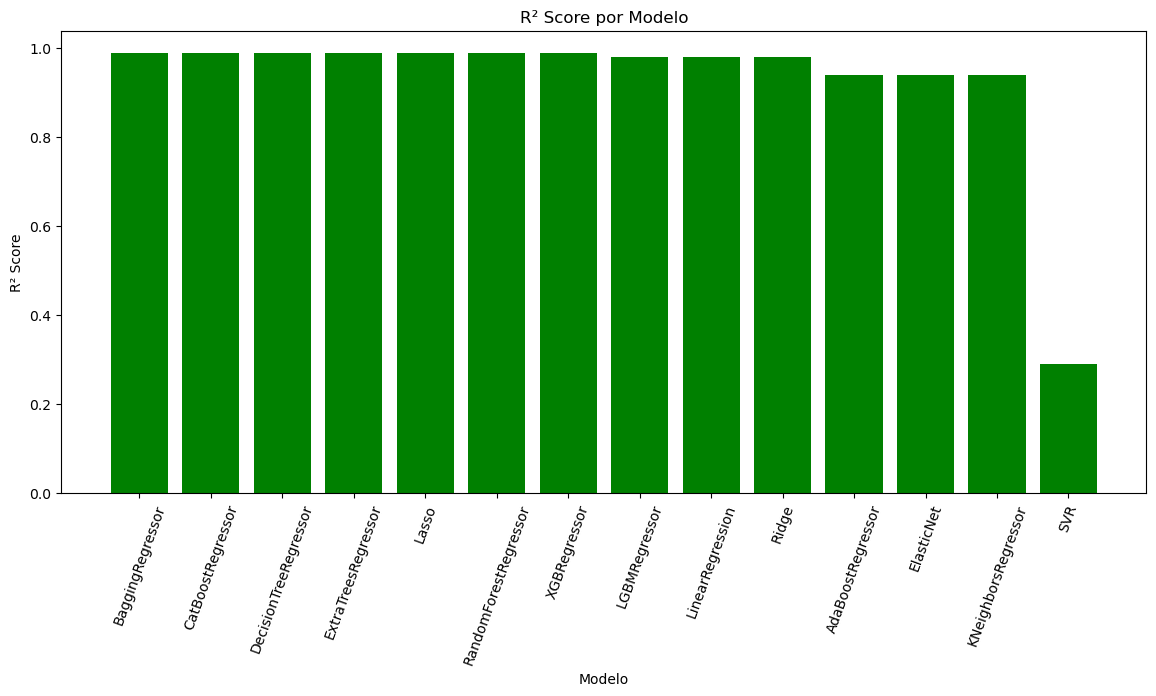

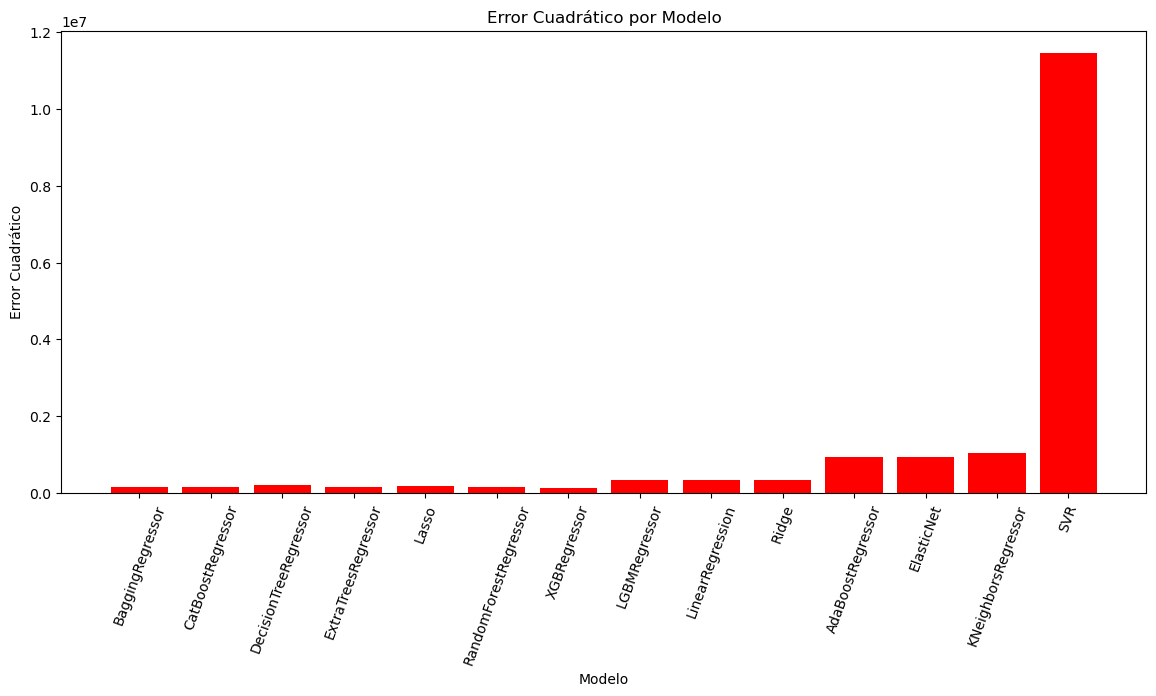

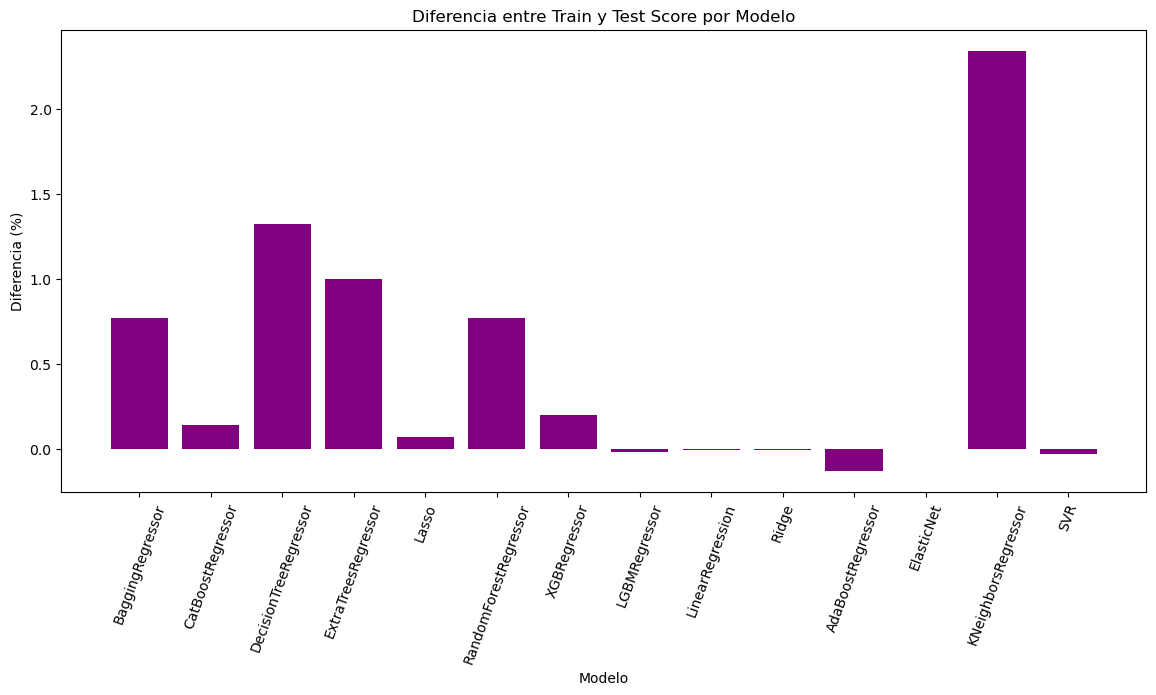

In [28]:
# Gráfica de Barras de los Puntajes de Entrenamiento y Prueba
plt.figure(figsize=(14, 6))
plt.bar(model_score['Modelo'], model_score['Train score'].str.rstrip('%').astype(float), color='blue', alpha=0.6, label='Train Score')
plt.bar(model_score['Modelo'], model_score['Test score'].str.rstrip('%').astype(float), color='orange', alpha=0.6, label='Test Score')
plt.xticks(rotation=70)
plt.title('Puntajes de Entrenamiento y Prueba por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Score (%)')
plt.legend()
plt.show()

# Gráfica de R² Score
plt.figure(figsize=(14, 6))
plt.bar(model_score['Modelo'], model_score['R² score'].astype(float), color='green')
plt.xticks(rotation=70)
plt.title('R² Score por Modelo')
plt.xlabel('Modelo')
plt.ylabel('R² Score')
plt.show()

# Gráfica de Errores Cuadráticos (Squared Error)
plt.figure(figsize=(14, 6))
plt.bar(model_score['Modelo'], model_score['Squared error'].str.rstrip('%').astype(float), color='red')
plt.xticks(rotation=70)
plt.title('Error Cuadrático por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Error Cuadrático')
plt.show()

# Gráfica de Diferencia entre Train y Test Score
plt.figure(figsize=(14, 6))
train_test_diff = model_score['Train score'].str.rstrip('%').astype(float) - model_score['Test score'].str.rstrip('%').astype(float)
plt.bar(model_score['Modelo'], train_test_diff, color='purple')
plt.xticks(rotation=70)
plt.title('Diferencia entre Train y Test Score por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Diferencia (%)')
plt.show()
